

```
Please run this file in google colab
```



In [ ]:
%%time
#@title setup
unified_memory = True
import os, time, gc
if unified_memory:
  ENV = {"TF_FORCE_UNIFIED_MEMORY":"1", "XLA_PYTHON_CLIENT_MEM_FRACTION":"4.0"}
  for k,v in ENV.items(): os.environ[k] = v
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@gamma")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")

  # install hhsuite
  print("installing HHsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading AlphaFold params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)
if "hhsuite" not in os.environ['PATH']:
  os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"


CPU times: user 714 µs, sys: 0 ns, total: 714 µs
Wall time: 4.05 ms


In [ ]:
import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.af.contrib.cyclic import add_cyclic_offset
from colabdesign.shared.protein import _np_rmsd, _np_kabsch
from colabdesign.shared.plot import plot_pseudo_3D, pymol_cmap
import colabdesign.af.contrib.extended_ptm as extended_ptm

import jax
import jax.numpy as jnp
from colabfold_utils import run_mmseqs2
import matplotlib.pyplot as plt
import string
import numpy as np

In [ ]:
def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

In [ ]:
def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.cif -P tmp/")
    return f"tmp/{pdb_code}.cif"
  else:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb -P tmp/")
    return f"tmp/AF-{pdb_code}-F1-model_v4.pdb"

In [ ]:
def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = predict.parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

In [ ]:
def run_do_not_align(query_sequence, target_sequence, **arg):
  return [query_sequence,target_sequence],[0,0]

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

In [ ]:
@jax.jit
def get_coevolution(X):
  '''given one-hot encoded MSA, return contacts'''
  Y = jax.nn.one_hot(X,22)
  N,L,A = Y.shape
  Y_flat = Y.reshape(N,-1)
  # covariance
  c = jnp.cov(Y_flat.T)

  # inverse covariance
  shrink = 4.5/jnp.sqrt(N) * jnp.eye(c.shape[0])
  ic = jnp.linalg.inv(c + shrink)

  # partial correlation coefficient
  ic_diag = jnp.diag(ic)
  pcc = ic / jnp.sqrt(ic_diag[:,None] * ic_diag[None,:])

  raw = jnp.sqrt(jnp.square(pcc.reshape(L,A,L,A)[:,:20,:,:20]).sum((1,3)))
  i = jnp.arange(L)
  raw = raw.at[i,i].set(0)
  # do apc
  ap = raw.sum(0,keepdims=True) * raw.sum(1,keepdims=True) / raw.sum()
  return (raw - ap).at[i,i].set(0)

In [ ]:
def plot_3D(aux, Ls, file_name, show=False):
  plt.figure(figsize=(10,5))
  xyz = aux["atom_positions"][:,1]
  xyz = xyz @ _np_kabsch(xyz, xyz, return_v=True, use_jax=False)
  ax = plt.subplot(1,2,1)
  if len(Ls) > 1:
    plt.title("chain")
    c = np.concatenate([[n]*L for n,L in enumerate(Ls)])
    plot_pseudo_3D(xyz=xyz, c=c, cmap=pymol_cmap, cmin=0, cmax=39, Ls=Ls, ax=ax)
  else:
    plt.title("length")
    plot_pseudo_3D(xyz=xyz, Ls=Ls, ax=ax)
  plt.axis(False)
  ax = plt.subplot(1,2,2)
  plt.title("plddt")
  plot_pseudo_3D(xyz=xyz, c=aux["plddt"], cmin=0.5, cmax=0.9, Ls=Ls, ax=ax)
  plt.axis(False)
  plt.savefig(file_name, dpi=200, bbox_inches='tight')
  plt.show() if show else plt.close()

In [ ]:
def run_mmseqs2_wrapper(*args, **kwargs):
  kwargs['user_agent'] = "colabdesign/gamma"
  return run_mmseqs2(*args, **kwargs)

In [ ]:
#@title prep_inputs
sequence = "KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL" #@param {type:"string"}
jobname = "test1" #@param {type:"string"}

copies = 1
msa_method = "mmseqs2"
pair_mode = "unpaired_paired"

cov = 75 # ["0", "25", "50", "75", "90", "99"] {type:"raw"}
id = 90 # ["90", "100"] {type:"raw"}
qid = 0 # ["0", "10", "15", "20", "30"] {type:"raw"}
do_not_filter = False

template_mode = "mmseqs2"
use_templates = template_mode in ["mmseqs2","custom"]
pdb = ""
chain = "A"
rm_template_seq = False
propagate_to_copies = True
do_not_align = False
rm_sidechain = rm_sequence = rm_template_seq

# filter options
sequence = sequence.upper()
sequence = re.sub("[^A-Z:/()]", "", sequence.upper())
sequence = re.sub("\(",":(", sequence)
sequence = re.sub("\)","):", sequence)
sequence = re.sub(":+",":",sequence)
sequence = re.sub("/+","/",sequence)
sequence = re.sub("^[:/]+","",sequence)
sequence = re.sub("[:/]+$","",sequence)
jobname = re.sub(r'\W+', '', jobname)

# process sequence
sequences = sequence.split(":")
sub_seq = "".join(sequences)
seq = sub_seq * copies
u_lengths = [len(x) for x in sequences]

jobname = f"{jobname}_{predict.get_hash(seq)[:5]}"
def check(folder): return os.path.exists(folder)
if check(jobname):
  n = 0
  while check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

print("Input Sequence", sequences)
print("Length of Input Sequence", len(sequences[0]))
print("Jobname",jobname)

input_opts = {"sequence":sequences,
              "copies":copies,
              "msa_method":msa_method,
              "pair_mode":pair_mode,
              "do_not_filter":do_not_filter,
              "cov":cov,
              "id":id,
              "template_mode":template_mode,
              "propagate_to_copies":True}

def run_mmseqs2_wrapper(*args, **kwargs):
  kwargs['user_agent'] = "colabdesign/gamma"
  return run_mmseqs2(*args, **kwargs)


Input Sequence ['KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL']
Length of Input Sequence 129
Jobname test1_ce6c6_0


getting unpaired MSA


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


parsing msas
gathering info
filtering sequences
selecting final sequences


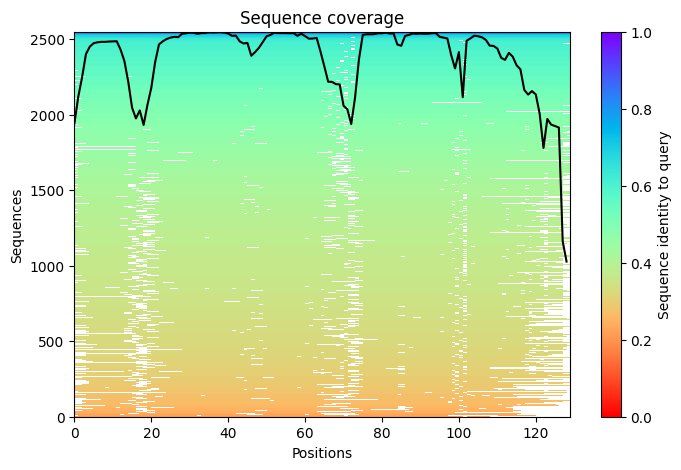

In [ ]:
##################
# GET MSA - for evolutionary information
##################
# Steps in get msa -
# 1. Do 1 hot encoding for amino acids
# 2. Get all msas paired and unpaired
# 3. Filter rceived msa on number of gaps,
# 4. return msa and deletion matrix


os.makedirs(jobname, exist_ok=True)

Ls = [len(x) for x in sequences]
msa, deletion_matrix = predict.get_msa(sequences, jobname,
    mode=pair_mode,
    cov=cov, id=id, qid=qid, max_msa=4096,
    do_not_filter=do_not_filter,
    mmseqs2_fn=run_mmseqs2_wrapper,
    hhfilter_fn=run_hhfilter)

if len(msa) > 1:
  predict.plot_msa(msa, Ls)
  plt.savefig(f"{jobname}/msa_feats.png", dpi=200, bbox_inches='tight')
  plt.show()


In [ ]:
##################
# Output from GET MSA - for evolutionary information
##################

from colabdesign.af.alphafold.common import residue_constants
aa_order = {a:n for n,a in enumerate(residue_constants.restypes + ["X","-"])}
idx_to_aa = {v: k for k, v in aa_order.items()}


def convert_numeric_msa_to_aa(numeric_msa):
    aa_msa = []
    for sequence in numeric_msa:
        aa_sequence = ''.join([idx_to_aa.get(idx, 'X') for idx in sequence])
        aa_msa.append(aa_sequence)
    return aa_msa

aa_msa = convert_numeric_msa_to_aa(msa)
print("Input:", sequences[0])
for i in range(min(5, len(aa_msa))):
    print("MSA_"+str(i)+":",aa_msa[i])

Input: KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL
MSA_0: KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL
MSA_1: KVFERCELAKKLKISGLDGYQGYSLPNWVCLSFYESRFNTQAVNHNTDRSTDYGIFQINSRWWCEDGKTPHSKNACNIPCSRLLDDDITDDIQCAKRVVRDPNGMKAWVAWRKFCEGQDLTKYTAGCGV
MSA_2: KIYGRCELAAAMKRLGLDNFRGYSLAHWVCTAKFESGFNTGAINRNRDGSSDYGILQINSRWWCNDGRTPRAKNGCNIPCSALLSSDITASVNCAKKVVSDKNGMNAWVAWRNHCKGRDVSQWIRGCRL
MSA_3: KKYERCELARELKASGLDGYWGYSLPNWVCLSEWESGYNTAAINHNSDGSTDYGIFQINSRWWCEDGKTPRSKDACGIFCSQLLTNDITVAIQCAKRVVRDPNGMSAWVAWRNHCQGRDLSQYTADCGV
MSA_4: KTFQRCELAKLLKASGMDGYRRVSLPNWVCMASFESRYDTMARNYNRDGSTDYGIFQINSRWWCEDGETPGSKNACKISCNALQNDDITDDIKCAKRVVQDPNGMRAWVAWRLYCAGKDLTKYLEDCDL


aligning template
getting unpaired MSA
ID	pdb	cid	evalue
101	1ior_A	0.984	2.201E-61
101	1ioq_A	0.984	1.068E-60
101	1iot_A	0.992	2.754E-60
101	1kxw_A	0.992	3.778E-60
PDBs [['1ior'], ['1ioq'], ['1iot'], ['1kxw']] [['A'], ['A'], ['A'], ['A']]


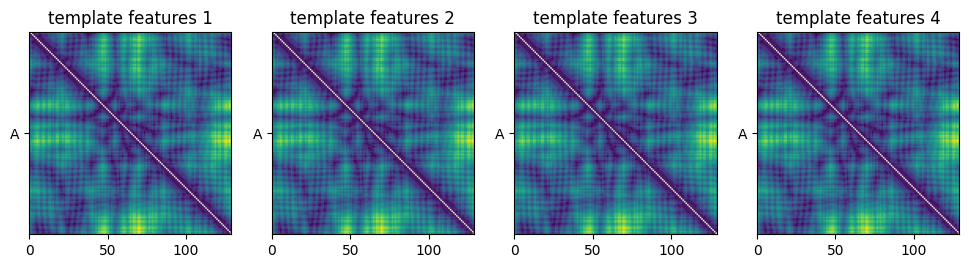

GC 16921


In [ ]:
##################
# GET Structural information - mode unpaired and do_not_filter = true
##################


if use_templates:
  print("aligning template")
  template_msa = f"{jobname}/msa.a3m"
  if template_mode == "mmseqs2":
    predict.get_msa(sequences, jobname,
      mode="unpaired",
      mmseqs2_fn=run_mmseqs2_wrapper,
      do_not_filter=True,
      do_not_return=True,
      output_a3m=f"{jobname}/msa_tmp.a3m")
    template_msa = f"{jobname}/msa_tmp.a3m"

    templates = {}
    print("ID\tpdb\tcid\tevalue")
    for line in open(f"{jobname}/msa/_env/pdb70.m8","r"):
      p = line.rstrip().split()
      # print(p)
      M,target_id,qid,e_value = p[0],p[1],p[2],p[10]
      M = int(M)
      if M not in templates:
        templates[M] = []
      if len(templates[M]) < 4:
        print(f"{int(M)}\t{target_id}\t{qid}\t{e_value}")
        templates[M].append(target_id)
    if len(templates) == 0:
      use_templates = False
      print("ERROR: no templates found...")
    else:
      Ms = sorted(list(templates.keys()))
      # print(Ms)
      pdbs,chains = [],[]
      for M in Ms:
        for n,target_id in enumerate(templates[M]):
          pdb_id,chain_id = target_id.split("_")
          if len(pdbs) < n+1:
            pdbs.append([])
            chains.append([])
          pdbs[n].append(pdb_id)
          chains[n].append(chain_id)
      print("PDBs",pdbs, chains)
  else:
    pdbs,chains = [pdb],[chain]

## get structural featues from above msas
if use_templates:
  input_opts.update({"pdbs":pdbs, "chains":chains})
  batches = []
  for pdb,chain in zip(pdbs,chains):
    query_seq = "".join(sequences)
    batch = predict.get_template_feats(pdb, chain,
      query_seq=query_seq,
      query_a3m=template_msa,
      copies=copies,
      propagate_to_copies=True,
      use_seq=not rm_sequence,
      get_pdb_fn=get_pdb,
      align_fn=run_do_not_align if do_not_align else run_hhalign)
    batches.append(batch)


  # for display
  plt.figure(figsize=(3*len(batches),3))
  for n,batch in enumerate(batches):
    plt.subplot(1,len(batches),n+1)
    plt.title(f"template features {n+1}")
    dgram = batch["dgram"].argmax(-1).astype(float)
    dgram[batch["dgram"].sum(-1) == 0] = np.nan
    Ln = dgram.shape[0]
    plt.imshow(dgram, extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls * copies)
  plt.savefig(f"{jobname}/template_feats.png", dpi=200, bbox_inches='tight')
  plt.show()
else:
  batches = [None]

################
print("GC",gc.collect())

In [ ]:
#@title prep_model
model_type = "auto"
rank_by = "plddt"
debug = False
use_initial_guess = False

num_msa = 512
num_extra_msa = 1024
use_cluster_profile = True

calc_extended_ptm = True
if len(Ls) == 1 and copies == 1:
  calc_extended_ptm = False

if calc_extended_ptm:
  debug=True

use_multimer = False
pseudo_multimer = False
rank_by = "plddt"

model_opts = {"num_msa":num_msa,
              "num_extra_msa":num_extra_msa,
              "num_templates":len(batches),
              "use_cluster_profile":use_cluster_profile,
              "use_multimer":use_multimer,
              "pseudo_multimer":pseudo_multimer,
              "use_templates":use_templates,
              "use_batch_as_template":False,
              "use_dgram":True,
              "protocol":"hallucination",
              "best_metric":rank_by,
              "optimize_seq":False,
              "debug":debug,
              "clear_prev":False}

# initialize the model
if "af" in dir():
  # reuse the model and/or params if already initialized
  if model_opts != model_opts_:
    if model_opts["use_multimer"] == af._args["use_multimer"] \
    and model_opts["use_templates"] == af._args["use_templates"]:
      old_params = dict(zip(af._model_names,af._model_params))
    else:
      print("loading alphafold params")
      old_params = {}
      clear_mem()
    af = mk_af_model(old_params=old_params,
                     use_mlm=True, # can be disabled later with 0% masking
                     **model_opts)
    model_opts_ = predict.copy_dict(model_opts)
else:
  print("loading alphafold params")
  af = mk_af_model(use_mlm=True,
                   **model_opts)
  model_opts_ = predict.copy_dict(model_opts)

# prep inputs
af.prep_inputs(u_lengths, copies=copies, seed=0)
print_key = ["plddt","ptm"]
if len(af._lengths) > 1: print_key += ["i_ptm", "multi"]

# for contact map
af.set_opt("con",cutoff=8.0)

# set templates
if use_templates:

  # interchain masking determined by dgram
  af._inputs["interchain_mask"] = np.full_like(af._inputs["interchain_mask"],True)

  af.set_opt(use_initial_guess=use_initial_guess)
  for n,batch in enumerate(batches):
    af.set_template(batch=batch, n=n)
  af.set_opt("template",
             rm_sc=rm_sidechain,
             rm_seq=rm_sequence)
# set msa
af.set_msa(msa, deletion_matrix)

loading alphafold params


running prediction
seed=0 model=model_1_ptm recycle=0 plddt=0.982 ptm=0.903
seed=0 model=model_1_ptm recycle=1 plddt=0.983 ptm=0.907 rmsd_tol=0.075


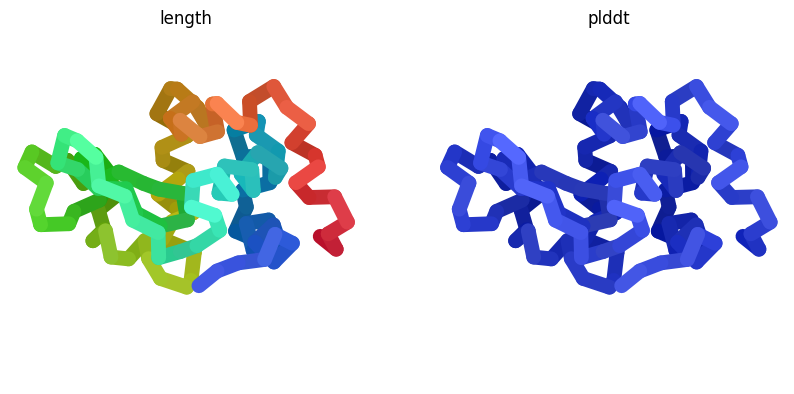

seed=0 model=model_2_ptm recycle=0 plddt=0.983 ptm=0.910
seed=0 model=model_2_ptm recycle=1 plddt=0.984 ptm=0.913 rmsd_tol=0.088


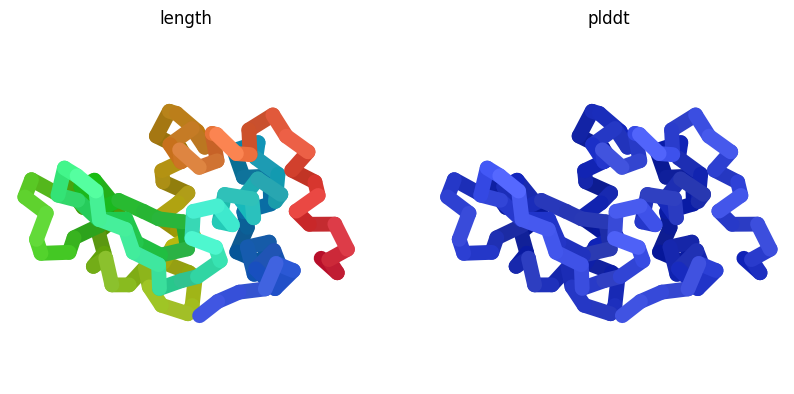

best_tag=model_2_ptm_r1_seed0 seed=0 model=model_2_ptm recycle=1 plddt=0.984 ptm=0.913 rmsd_tol=0.088
GC 16476
CPU times: user 1min 10s, sys: 4.13 s, total: 1min 14s
Wall time: 1min 17s


In [ ]:
%%time
#@title run_alphafold
model = "all"
num_recycles = 6
recycle_early_stop_tolerance = 0.5
select_best_across_recycles = False

use_mlm = True
use_dropout = False
seed = 0
num_seeds = 1
show_images = True

run_opts = {"seed":seed,
            "use_mlm":use_mlm,
            "use_dropout":use_dropout,
            "num_recycles":num_recycles,
            "model":model,
            "use_initial_guess":use_initial_guess,
            "select_best_across_recycles":select_best_across_recycles,
            "recycle_early_stop_tolerance":recycle_early_stop_tolerance}

# decide which models to use
if model == "all": models = af._model_names
else: models = [af._model_names[int(model) - 1]]

# set options
af.set_opt("mlm", replace_fraction=0.15 if use_mlm else 0.0)

pdb_path = f"{jobname}/pdb"
os.makedirs(pdb_path, exist_ok=True)

# keep track of results
info = []
af._tmp = {"traj":{"seq":[],"xyz":[],"plddt":[],"pae":[]},
           "log":[],"best":{}}

# run
print("running prediction")
with open(f"{jobname}/log.txt","w") as handle:
  # go through all seeds
  seeds = list(range(seed,seed+num_seeds))
  for seed in seeds:
    af.set_seed(seed)
    # go through all models
    for model in models:
      recycle = 0
      af._inputs.pop("prev",None)
      stop_recycle = False
      prev_pos = None
      # go through all recycles
      while recycle < num_recycles + 1:
        print_str = f"seed={seed} model={model} recycle={recycle}"
        af.predict(dropout=use_dropout, models=[model], verbose=False)

        # set previous inputs
        af._inputs["prev"] = af.aux["prev"]

        # save results
        if len(af._lengths) > 1:
          af.aux["log"]["multi"] = 0.8 * af.aux["log"]["i_ptm"] + 0.2 * af.aux["log"]["ptm"]
        af.save_current_pdb(f"{pdb_path}/{model}_r{recycle}_seed{seed}.pdb")

        # print metrics
        for k in print_key: print_str += f" {k}={af.aux['log'][k]:.3f}"

        # early stop check
        current_pos = af.aux["atom_positions"][:,1]
        if recycle > 0:
          rmsd_tol = _np_rmsd(prev_pos, current_pos, use_jax=False)
          if rmsd_tol < recycle_early_stop_tolerance:
            stop_recycle = True
          print_str += f" rmsd_tol={rmsd_tol:.3f}"
        prev_pos = current_pos
        # print metrics
        print(print_str); handle.write(f"{print_str}\n")

        tag = f"{model}_r{recycle}_seed{seed}"
        if select_best_across_recycles:
          info.append([tag,print_str,af.aux["log"][rank_by]])
          if calc_extended_ptm:
            extended_ptms = extended_ptm.get_chain_and_interface_metrics(af.aux['debug']['outputs'], af._inputs['asym_id'])
            info[-1].extend([extended_ptms['pairwise_iptm'], extended_ptms['pairwise_actifptm'], extended_ptms['per_chain_ptm']])
          af._save_results(save_best=True,
                           best_metric=rank_by, metric_higher_better=True,
                           verbose=False)
          af._k += 1

        recycle += 1
        if stop_recycle: break

      if not select_best_across_recycles:
        info.append([tag,print_str,af.aux["log"][rank_by]])
        if calc_extended_ptm:
          extended_ptms = extended_ptm.get_chain_and_interface_metrics(af.aux['debug']['outputs'], af._inputs['asym_id'])
          info[-1].extend([extended_ptms['pairwise_iptm'], extended_ptms['pairwise_actifptm'], extended_ptms['per_chain_ptm']])
        af._save_results(save_best=True,
                         best_metric=rank_by, metric_higher_better=True,
                         verbose=False)
        af._k += 1

      # save current results
      plot_3D(af.aux, Ls * copies, f"{pdb_path}/{model}_seed{seed}.pdf", show=show_images)
      predict.plot_confidence(af.aux["plddt"]*100, af.aux["pae"], Ls * copies)
      plt.savefig(f"{pdb_path}/{model}_seed{seed}.png", dpi=200, bbox_inches='tight')
      plt.close()

# save best results
rank = np.argsort([x[2] for x in info])[::-1][:5]
print(f"best_tag={info[rank[0]][0]} {info[rank[0]][1]}")

aux_best = af._tmp["best"]["aux"]
af.save_pdb(f"{pdb_path}/best.pdb")
plot_3D(aux_best, Ls * copies, f"{pdb_path}/best.pdf", show=False)
predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], Ls * copies)
plt.savefig(f"{pdb_path}/best.png", dpi=200, bbox_inches='tight')
plt.close()

# garbage collection
print("GC",gc.collect())

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

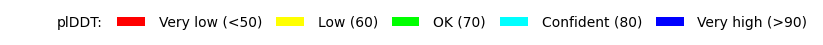

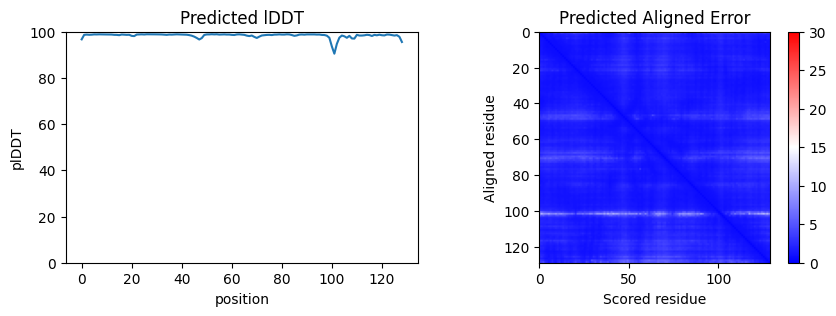

In [ ]:
#@title display_best_result
color = "pLDDT"
show_sidechains = False
show_mainchains = False
color_HP = True

af.plot_pdb(color=color, show_sidechains=show_sidechains, show_mainchains=show_mainchains, color_HP=color_HP)
predict.plot_plddt_legend().show()
aux_best = af._tmp["best"]["aux"]
predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], u_lengths * copies).show()

In [ ]:
# Install BioPython if you haven't already
!pip install biopython

from Bio.PDB import PDBList
pdbl = PDBList()
pdbl.retrieve_pdb_file('1LYZ', pdir='./temp', file_format='pdb')

'./temp/pdb1lyz.ent'

In [ ]:
# Import required libraries
import py3Dmol
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import HTML, display

def display_pdb_structure(pdb_path, title, width=800, height=400, color_scheme='spectrum'):
    # Create a py3Dmol view
    view = py3Dmol.view(width=width, height=height)

    # Read PDB file
    with open(pdb_path, 'r') as f:
        pdb_data = f.read()

    # Add the model to the view
    view.addModel(pdb_data, 'pdb')

    # Set style and color
    if color_scheme == 'bfactor':
        view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 0, 'max': 100}}})
    elif color_scheme == 'chainname':
        view.setStyle({'cartoon': {'color': 'chainname'}})
    else:
        view.setStyle({'cartoon': {'color': color_scheme}})

    # Add surface representation
    view.addSurface(py3Dmol.VDW, {'opacity': 0.4, 'colorscheme': color_scheme})

    # Zoom to fit the model
    view.zoomTo()

    # Display the title and the view
    display(HTML(f"<h3>{title}</h3>"))
    display(view)
    print(f"Visualization of {title} using py3Dmol")

    # Add a spacing after the structure
    display(HTML("<hr>"))

# Example usage:
# Display predicted structure (from your alphafold run)
# Replace with your actual paths
jobname = "test"  # Update with your actual jobname
predicted_path = f"{pdb_path}/best.pdb"

# Display structures one below the other
display_pdb_structure(predicted_path, "AlphaFold Prediction", color_scheme='bfactor')
display_pdb_structure("./temp/pdb1lyz.ent", "Experimental Structure (1LYZ)", color_scheme='chainname')


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Visualization of AlphaFold Prediction using py3Dmol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Visualization of Experimental Structure (1LYZ) using py3Dmol
